## Hands-on session 2.3 - CRM basics with ReMKiT1D

In this session we cover the basics of CRM construction for use in ReMKiT1D models. The example is focused on a small set of equations, in order to demonstrate the general concepts. 

Demonstrated concepts:

- Setting species and associating variables to them 
- Simple and derived transitions 
- Constructing CRM modelbound data from transitions
- Adding term generators that use CRM modelbound data
- The extractor manipulator

A number of CRM concepts are beyond this workshop. These include:

- Kinetic features - Boltzmann term generators 
- Built-in Janev hydrogen transitions 
- Using external databases such as AMJUEL to construct polynomial fits 
- Other kinds of transitions (detailed balance etc.)

In [1]:
from RMK_support import RKWrapper ,Grid, Node, treeDerivation
import RMK_support.simple_containers as sc
import RMK_support.IO_support as io
import RMK_support.dashboard_support as ds 
import RMK_support.crm_support as crm

import numpy as np
import holoviews as hv 
import panel as pn
import matplotlib.pyplot as plt

### Wrapper initialization

In [2]:
rk = RKWrapper()

### Global parameters for writing the files

In [3]:
rk.jsonFilepath = "./config.json" # Default value
hdf5Filepath = "./RMKOutput/day_2_3/"
rk.setHDF5Path(hdf5Filepath) 

### Grid initialization

We initialize 0D grid as in the previous session

In [4]:
rk.grid = Grid(np.zeros(1))

### A simplified Collisional Radiative Model 

Let's write a simplified nonlinear time-dependent CRM. 

Let's assume we're working with electrons, singly-charged ions, a ground state and an excited neutral state. This implies that we are tracking the following densities:

$$n_e,n_i,n_1,n_2$$

Let's then say we have the following reactions in the system:

- Electron-impact ionization of both states 

$$ e + b \rightarrow i + e + e,\quad b=1,2$$  

- The direct inverse of the above reaction - three-body recombination

$$ i + e + e \rightarrow b + e,\quad b=1,2$$  

- Electron impact excitation from state 1 to state 2

$$ e + 1 \rightarrow e + 2$$  

- Radiative de-excitation (spontaneous emission) from state 2 to state 1 

$$ n_2 \rightarrow n_1 + h\nu$$ 
where $h\nu$ signifies a photon with the transition energy. We will assume that any energy losses are recuperated through some heating of the electrons, maintaining a constant electron temperature. This is assumption can be relaxed, but required the evolution of electron energy and unduly complicated this system.

The system described above can be represented with the following system of nonlinear ODEs

$$ \frac{d n_1}{dt} = -K_{12}n_en_1 - K_1^{ion}n_en_1 + A_{21}n_2 + K_1^{rec}n_e^2n_i $$

$$ \frac{d n_2}{dt} = K_{12}n_en_1 - K_2^{ion}n_en_2 - A_{21}n_2 + K_2^{rec}n_e^2n_i $$
$$ \frac{d n_e}{dt} = \frac{d n_i}{dt} =  K_1^{ion}n_en_1 + K_2^{ion}n_en_2 - (K_1^{rec} + K_2^{rec})n_e^2n_i$$

In this case, one could simplify the system by dropping the ion density equation, but in we might want to track many different ionization states so $n_e \neq n_i$ in general.

Even though we have only 6 reactions, the number of terms (ignoring potentially simplifying groupings) in this system is 16. The CRM features in ReMKiT1D are meant to simplify the building of many related terms, such as these. 

**NOTE**: In this notebook we are not concerned with physical validity. The rate values and expressions are not relevant to any real physical process. We instead focus on how one would build up an arbitrary CRM. As such, everything is in arbitrary units.

### Species information in ReMKiT1D

Many built-in terms and models, including those generated with CRM term generators, require knowledge of the species they are being constructed for. This includes both basic information about the species (such as atomic mass and charge), as well as any associated variables and unique IDs.

**NOTE**: ReMKiT1D enforces that the electron species, with name "e" has the speciesID of 0. Other than that, the convention so far in ReMKiT1D has been that non-electron charged species get negative indices and neutral species get positive indices. 

Let's add the species present in the toy model we just made. Note that the mass and charge values are not used by the CRM data. Add the remaining variables below, making sure you associate the densities of the species.

In [5]:
# Electron species have an automatically set mass and charge
rk.addSpecies(name="e",speciesID=0,associatedVars=["ne"]) # ReMKiT1D will detect the electron species automatically and populate the mass and charge fields
rk.addSpecies(name="i",speciesID=-1,associatedVars=["ni"], charge = 1.0, atomicA = 1.0)
rk.addSpecies(name="1",speciesID=1,associatedVars=["n1"], charge = 0.0, atomicA = 1.0)
rk.addSpecies(name="2",speciesID=2,associatedVars=["n2"], charge = 0.0, atomicA = 1.0)
#[YOUR CODE HERE]

As you can see, we've already associated the variables we'd like to use. They don't need to be added to the wrapper yet. Let us add them as before.

### Variables 

We have to add the four densities we're evolving. Initialize them using the provided values.

In [6]:
ne = ni = np.ones(1)

n1 = 0.5*np.ones(1)

n2 = np.zeros(1)

rk.addVar("ne", ne)
rk.addVar("ni", ni)
rk.addVar("n1", n1)
rk.addVar("n2", n2)

# [YOUR CODE HERE]

Let's also add a dummy variable for the electron temperatue so we can demonstrate derived transitions further down. We also need to add the time variable, as always.

In [7]:
# I think when you put isDerived=True you mark that they are not evolved, but then
# you are allowed to not pass a derivation rule which makes them stuck at the initial condition.

Te = 5*np.ones(1)
rk.addVar("Te", Te, isDerived=True)

rk.addVar("time", isScalar=True, isDerived=True)

# [YOUR CODE HERE]

### Constructing the CRM modelbound data object

We can now start working with the CRM modelbound data object. We use the `crm_support` module to simplify this process. 

In [8]:
crmData = crm.ModelboundCRMData()

To add a transition with a constant rate and transition energy we use the `simpleTransition` function in `crm_support`. Let's use this to add the spontaneous emission reaction. Complete the call to `simpleTransition` by setting the `inState` and `outState` arguments.

In [9]:
spontEmission = crm.simpleTransition(inState = 2, outState = 1, transitionEnergy=-10,transitionRate=0.3)

crmData.addTransition("spontEmission",transitionProperties=spontEmission)

To add a transition with one or more of the rates calculated using a derivation we use `derivedTransition`.

When using `derivedTransition`s we must supply at least one derivation rule - the rule for the transition rate itself. Momentum and energy rate derivations can also be supplied. If the energy rate is not supplied, it is calculated as `transitionRate*transitionEnergy`. We do not use the energy or momentum rates in terms in this example. but we will show how they can be accessed below. 

Let's add the ionization and recombination rates. To loosly mimic how these behave in reality, let's make them proportional to $T_e$ and $n_e^2/T_e$, respectively. We use the Node/treeDerivation approach. Complete the below derivations keeping the supplied proportionality constants.

In [10]:
rk.addCustomDerivation("ion1",derivOptions=treeDerivation(0.2 * Node("Te"))) #[YOUR CODE HERE]
rk.addCustomDerivation("recomb1",derivOptions=treeDerivation(0.2 * Node("ne")**2 / Node("Te"))) #[YOUR CODE HERE]

rk.addCustomDerivation("ion2",derivOptions=treeDerivation(0.8 * Node("Te"))) #[YOUR CODE HERE]
rk.addCustomDerivation("recomb2",derivOptions=treeDerivation(0.8 * Node("ne")**2 / Node("Te"))) #[YOUR CODE HERE]

Complete the below transition definitions

In [11]:
# The states are actually IDs
# The order matters - the last species has to be the implicit (evolved) variable.

ion1 = crm.derivedTransition(inStates=[0,1],outStates=[0,0,-1],transitionEnergy=12,ruleName="ion1",requiredVars=["Te"]) #[YOUR CODE HERE]

ion2 = crm.derivedTransition(inStates=[0,2],outStates=[0,0,-1],transitionEnergy=2,ruleName="ion2",requiredVars=["Te"]) #[YOUR CODE HERE]

recomb1 = crm.derivedTransition(inStates=[0,0,-1],outStates=[0,1],transitionEnergy=-12,ruleName="recomb1",requiredVars=["ne", "Te"]) #[YOUR CODE HERE]

recomb2 = crm.derivedTransition(inStates=[0,0,-1],outStates=[0,2],transitionEnergy=-2,ruleName="recomb2",requiredVars=["ne", "Te"]) #[YOUR CODE HERE]

crmData.addTransition("ion1",ion1)
crmData.addTransition("ion2",ion2)
crmData.addTransition("recomb1",recomb1)
crmData.addTransition("recomb2",recomb2)

For excitation let's use the same proportionality as for ionization

In [12]:
rk.addCustomDerivation("exc",derivOptions=treeDerivation(0.3 * Node("Te"))) #[YOUR CODE HERE]

exc = crm.derivedTransition(inStates=[0,1],outStates=[0,2],transitionEnergy=10,ruleName="exc",requiredVars=["Te"]) #[YOUR CODE HERE]

crmData.addTransition("exc",exc)

### Build a model using CRM data and term generators

We can now use a term generator to generate the standard CRM rate terms from the modelbound data. First we need to build a model and add the modelbound data to it using the dictionary form of it as the argument to `setModelboundData`. 

In [13]:
#[YOUR CODE HERE]
crmModel = sc.CustomModel(modelTag="CRMmodel")
crmModel.setModelboundData(crmData.dict())

The standard term generator for CRMs will take all reactions and generate matrix terms with diagonal stencils evolving the first associated variable (densities) of the input and output states. The implict variable is chosen to be the final variable in the `inStates` list, so for [0,1] the implicit variable will be "n1". 

Finer control over the generated terms is possible by selecting which implicit group the terms should be added to, which transitions should be included, as well as which states should be evolved. We use the default term generator, which will evolve all states using all transitions, and have them all in one term group.

Use `addTermGenerator` to add the below object to your crm model. Do not forget to add the model to the wrapper!

In [14]:
crmTermGenerator = crm.termGeneratorCRM()
crmModel.addTermGenerator("crmTermGen",crmTermGenerator)

rk.addModel(crmModel)

Checking terms in model CRMmodel:


As you can see, your model has no terms, just a term generator.

### Extractor manipulator

We can directly extract variables from modelbound data using the `extractorManipulator` from `simple_containers`. Let's get the energy rate of the "recomb1" transition. This is the fourth added transition, and the energy moment is the second moment, so we will try to extract the modelbound variable `rate2index4` into the newly added variable `recombEn`.

Here we also come across manipulator priority. There are 5 possible priority levels, which each level including all those below it:

0. Manipulator is called on all internal integrator iterations (nonlinear BDE iterations in this case)
1. Manipulator is called at the end of each (internal) timestep (in any one integration step)
2. Manipulator is called at the end of each integration step (here there is only one integration step and no internal step timestep control so 1 and 2 would behave the same)
3. Manipulator is called at the end of each integration call (global timestep)
4. Manipulator is called before data writing to HDF5 file

Priority 4 is the default, and is in general used for diagnostic variables. At present, manipulators with priority > 4 are never called.

Add the new derived variable "recombEn", use `extractorManipulator` to specify the model, data name, and target variable name. You can add the manipulator to the wrapper using the wrapper's `addManipulator` function.

In [15]:
rk.addVar("recombEn",isDerived=True)

recombEn = sc.extractorManipulator(modelTag="CRMmodel",modelboundDataName="rate2index4",resultVarName="recombEn")

rk.addManipulator("recombEn",recombEn)

### Time integration

In [16]:
rk.addIntegrator("BE",sc.picardBDEIntegrator(nonlinTol=1e-12,absTol=10.0,convergenceVars=["ne","ni","n1","n2"])) 

rk.setIntegratorGlobalData(initialTimestep=0.0001) 

bdeStep = sc.IntegrationStep("BE")

for tag in rk.modelTags():
    bdeStep.addModel(tag)

rk.addIntegrationStep("StepBDE",bdeStep.dict())

rk.setFixedNumTimesteps(20000)
rk.setFixedStepOutput(400)

### Write config file

Remember to run ReMKiT1D with a single MPI process for this session.

In [17]:
rk.writeConfigFile()

### Data analysis

In [19]:
hv.extension('matplotlib')
%matplotlib inline 
plt.rcParams['figure.dpi'] = 150
hv.output(size=100,dpi=150)

numFiles=50
loadpath = rk.hdf5Filepath
loadFilenames = [loadpath+f'ReMKiT1DVarOutput_{i}.h5' for i in range(numFiles+1)]
loadedData = io.loadFromHDF5(rk.varCont, filepaths=loadFilenames)
loadedData

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

<xarray.Dataset>
Dimensions:   (x: 1, h: 1, v: 1, time: 51)
Coordinates:
  * x         (x) float64 0.0
  * h         (h) int64 0
  * v         (v) float64 1.0
  * time      (time) float64 0.0 0.04 0.08 0.12 0.16 ... 1.84 1.88 1.92 1.96 2.0
Data variables:
    ne        (time, x) float64 1.0 1.014 1.03 1.048 ... 1.308 1.308 1.308 1.309
    ni        (time, x) float64 1.0 1.014 1.03 1.048 ... 1.308 1.308 1.308 1.309
    n1        (time, x) float64 0.5 0.4539 0.412 ... 0.0596 0.05953 0.05947
    n2        (time, x) float64 0.0 0.03246 0.05805 ... 0.132 0.132 0.132
    Te        (time, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
    recombEn  (time, x) float64 0.0 -0.4932 -0.5091 ... -0.8217 -0.8218 -0.8219

Let's look at the evolution of the variables

:HoloMap   [x]
   :Overlay
      .Curve.Ne       :Curve   [time]   (ne)
      .Curve.Ni       :Curve   [time]   (ni)
      .Curve.N1       :Curve   [time]   (n1)
      .Curve.N2       :Curve   [time]   (n2)
      .Curve.RecombEn :Curve   [time]   (recombEn)
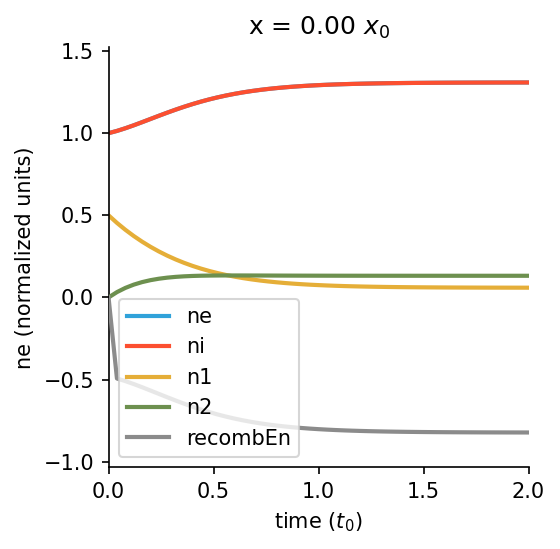

In [20]:
pn.extension(comms="vscode") # change comms if not using VSCode
dashboard = ds.ReMKiT1DDashboard(loadedData,rk.grid)

dashboard.fluidMultiComparison(["ne","ni","n1","n2","recombEn"],fixedPosition=True)